# Chapter 3: Classification

In [1]:
import numpy as np

## 3.1 MNIST

`MNIST dataset` is a dataset of small images of handwritten digits. Very popular and is the "hello world", introductory dataset of Machine Learning.

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

There are `70,000 images` and each image has `784 features (28 pixels * 28 pixels)`, and each feature = pixel intensity (0, white -> 255, black).

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

- Use `.iloc[]` for row indexing
- `"X[0]"` in book causes error since that defaults to column indexing


- Use `.values.reshape()` for Scikit-Learn Series reshaping  
- `.reshape(28, 28)` is depreciated in official docs


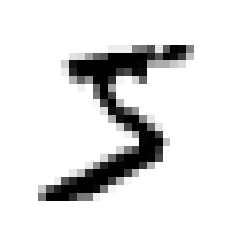

In [7]:
some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [8]:
y[0]

'5'

In [9]:
y = y.astype(np.uint8)
y[0]

5

Dataset has already split `training set (0:60,000)` and `test set (60,000:)`.  
Training set has also been shuffled already.

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 Training a Binary Classifier

Let's try to identify one digit - 5.  Construct a booleran array of which True means 5, False otherwise.

In [11]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Use Scikit-Learn's `SGDClassifier (Stochastic Gradient Descent)`.

In [12]:
from sklearn.linear_model import SGDClassifier

Set `random_state` parameter to remove randomness.

In [13]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 Performance Measures

### 3.3.1 Measuring Accuracy Using Cross-Validation

In some cases, creating own cross-valid set gives more control than Scikit-learn.

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

Note: `random_state=42` is not needed since shuffle is off by default.

In [16]:
skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565, and 0.96495

0.95035
0.96035
0.9604


Using Scikit-Learn's `cross_val_score()` to evalue the SGDClassifier.

In [17]:
from sklearn.model_selection import cross_val_score

In [18]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Let's compare to those in the 'not 5' class.

In [19]:
from sklearn.base import BaseEstimator

In [20]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

About 90% accurate to predicting not 5.  

`Recall: We constructed a binary classifier. It is a 5 or not 5.`  

Since only 10% of dataset are 5s, if we always guess image is not 5, we get right about 90% of the time.

### 3.3.2 Confusion Matrix

To evaluate performance of classifier, look at `confusion matrix` and count number of times instances of Class A are classified as Class B.  

Use `cross_val_predict()` to compare, leaving test set untouched.

In [22]:
from sklearn.model_selection import cross_val_predict

In [23]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [24]:
from sklearn.metrics import confusion_matrix

Each row represents an actual class, while each column represents a predicted class.  

1,1 : correct non-5 images or `true negatives`  
1,2 : wrong non-5 images or `false positives`  
2,1 : wrong 5 images or `false positives`  
2,2 : correct 5 images or `true positives`

In [25]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

A perfect confusion matrix would only have true positives and true negatives.  
Off-diagonal = 0

In [26]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Equation 3-1. Precision  

$$ precision = \frac{TP}{TP + FP}$$ where TP = `true positives` and FP = `false positives`

Equation 3-2. Recall  

$$ recall = \frac{TP}{TP + FN} $$

where TP = `true positives` and FN = `false negatives`

### 3.3.3 Precision and Recall

Scikit-Learn provides `precision_score` and `recall_score`.

In [27]:
from sklearn.metrics import precision_score, recall_score

In [28]:
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522) for book
                                         # == 3530 / (3530 + 687) for me

0.8370879772350012

In [30]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325) for book
                                      # == 3530 / (3530 + 1891) for me

0.6511713705958311

It is only correct 83% of the time, and only detects 65% of the 5s.

A better metric would be the $F_{1}$ score, the harmonic mean of precision and recall, `more weight to low values`.  

$\uparrow$$\uparrow$ $F_{1}$ scores only if $\uparrow$$\uparrow$ recall and $\uparrow$$\uparrow$ precision.

Equation 3-3. $F_{1}$

$$ F_{1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2\frac{precision * recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$$

In [32]:
from sklearn.metrics import f1_score

In [33]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3.3.4 Precision/Recall Trade-Off

### 3.3.5 The ROC Curve

## 3.4 Multiclass Classification

## 3.5 Error Analysis

## 3.6 Multilabel Classification

## 3.7 Multioutput Classification

## 3.8 Exercises